<div style="text-align: right">Data Sci Engineering Methods</div>
<div style="text-align: right">Gauri Verma (TA), 12 November 2021</div>

# Who will win the match?

### What are the chances of draw for Europe vs Non-Europe?

### MOM and pymc3 implementation

<img src="ipynb.images/soccer.jpg" width="400" height="200">

In [17]:
#importing necessary libraries
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson,skellam

In [18]:
df = pd.read_csv('results.csv')

In [19]:
df.shape

(42899, 9)

In [20]:
df.head(5)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


# Handling Outliers

> What is an outlier? 

An outlier is an observation of a data point that lies an abnormal distance from other values in a given population
In data science, we often want to make assumptions about a specific population. Extreme values, however, can have a significant impact on conclusions drawn from data or machine learning models. With outlier detection and treatment, anomalous observations are viewed as part of different populations to ensure stable findings for the population of interest.. 

#### It is pretty useless to count those teams that hardly played any matches over ALL these years! So getting the count and removing some of them would be good..

In [21]:
df['home_team'].value_counts()

Brazil                       583
Argentina                    560
Mexico                       528
Germany                      520
England                      515
                            ... 
Central Spain                  1
Crimea                         1
Saint Pierre and Miquelon      1
Saint Helena                   1
Chameria                       1
Name: home_team, Length: 308, dtype: int64

In [22]:
#teams like Chameria played 1 out of all the matches! It adds no value to our data..

array([[<AxesSubplot:title={'center':'home_score'}>]], dtype=object)

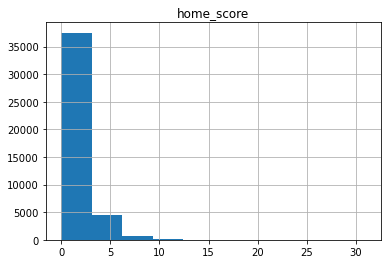

In [23]:
df.hist('home_score')

In [24]:
home_dict = df['home_team'].value_counts().to_dict()

In [25]:
away_dict = df['away_team'].value_counts().to_dict()

In [26]:
from collections import Counter
a_counter = Counter(home_dict)
b_counter = Counter(away_dict)
add_dict = a_counter + b_counter
total_dict = dict(add_dict)
print(total_dict)

{'Brazil': 1004, 'Argentina': 1001, 'Mexico': 895, 'Germany': 972, 'England': 1034, 'Sweden': 1041, 'France': 862, 'South Korea': 886, 'Hungary': 951, 'Italy': 825, 'United States': 707, 'Austria': 809, 'Netherlands': 807, 'Belgium': 791, 'Switzerland': 820, 'Denmark': 819, 'Norway': 821, 'Chile': 782, 'Poland': 837, 'Scotland': 800, 'Malaysia': 666, 'Japan': 660, 'Egypt': 641, 'Saudi Arabia': 635, 'Kenya': 654, 'Spain': 718, 'Uruguay': 904, 'China PR': 602, 'Malawi': 579, 'Finland': 766, 'Romania': 711, 'Indonesia': 571, 'Kuwait': 581, 'Portugal': 635, 'Thailand': 662, 'Wales': 678, 'Qatar': 553, 'Northern Ireland': 661, 'Republic of Ireland': 583, 'Costa Rica': 625, 'Trinidad and Tobago': 676, 'Russia': 715, 'Zambia': 739, 'Tunisia': 592, 'Bulgaria': 686, 'United Arab Emirates': 539, 'Bahrain': 505, 'Singapore': 566, 'Australia': 525, 'Greece': 582, 'Algeria': 515, 'El Salvador': 522, 'Jamaica': 578, 'Uganda': 632, 'Peru': 646, 'Morocco': 547, 'Ghana': 609, 'Iran': 509, 'Turkey': 589

In [27]:
total_games = pd.DataFrame(list(total_dict.items()),columns = ['Country','count_of_games'])

In [28]:
total_games.tail(10)

,Country,count_of_games
301,Madrid,1
302,Romani people,3
303,Central Spain,2
304,Crimea,5
305,Saint Pierre and Miquelon,7
306,Saint Helena,4
307,Chameria,5
308,Two Sicilies,4
309,Asturias,1
310,Surrey,1


C:\Users\19293\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


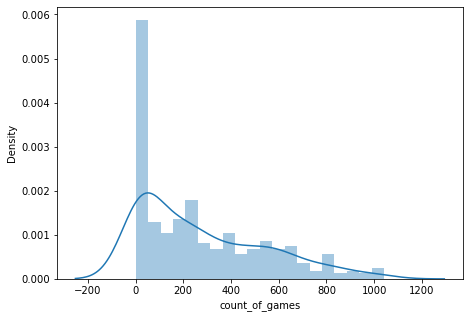

In [29]:
import seaborn as sns
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(total_games['count_of_games'], bins = 20)
plt.show()

C:\Users\19293\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


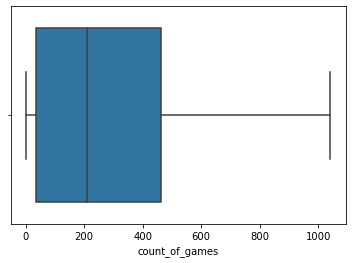

In [30]:
sns.boxplot(total_games['count_of_games'])
plt.show()

Sometimes box plots might not give you the information you are looking for, it is the intelligence of a data scientist to understand what the data represetns... something machines cannot do!

In [31]:
total_games.describe()

,count_of_games
count,311.000000
mean,275.877814
std,265.686484
min,1.000000
25%,34.000000
50%,210.000000
75%,463.500000
max,1041.000000


#### Since 25% accounts for 34 total games, taking lower bound 30 as the limit and removing teams that played A TOTAL of less than 30 matches

In [32]:
len(total_games.loc[total_games['count_of_games']<30])

72

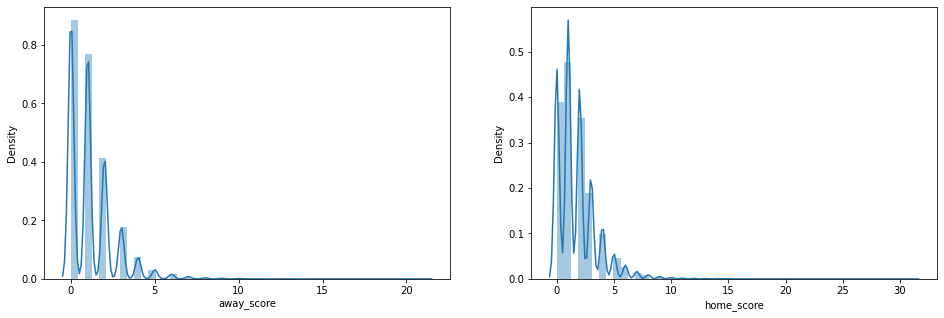

In [33]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(df['away_score'])
plt.subplot(1,2,2)
sns.distplot(df['home_score'])
plt.show()

In [34]:
less_played = total_games.loc[total_games['count_of_games']<30]

In [35]:
#bad_played.sort_values(by='count_of_games').head(30)

In [36]:
#taking only well played teams
decent_played = total_games.loc[total_games['count_of_games']>30]

In [37]:
decent_played.shape

(236, 2)

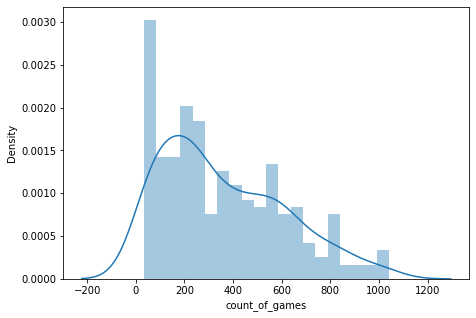

In [38]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(decent_played['count_of_games'], bins = 20)
plt.show()

In [39]:
#filtering data on those countries that played decent number of games

list_of_countries = decent_played['Country'].to_list()

In [40]:
df = df.loc[(df['home_team'].isin(list_of_countries)) | (df['away_team'].isin(list_of_countries))]

In [41]:
df.shape

(42686, 9)

## Now let's handle outliers for the scores : home_score and away_score the traditional way..

<AxesSubplot:xlabel='home_score'>

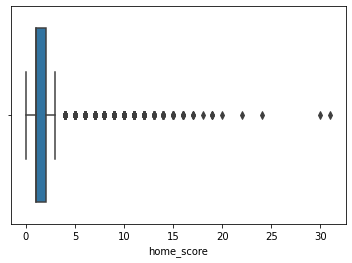

In [42]:
# Box Plot
import seaborn as sns
sns.boxplot(df['home_score'])

In [43]:
# box plot tells us that scores above 20 are outliers

In [44]:
df=df.reset_index()

Next to its visual benefits, the box plot provides useful statistics to identify individual observations as outliers. The **Turkey method** distinguishes between possible and probable outliers. A possible outlier is located between the inner and the outer fence, whereas a probable outlier is located outside the outer fence.


<img src="ipynb.images/turkey_method.jpg" width="800" height="400">


While the inner (often confused with the whiskers) and outer fence are usually not shown on the actual box plot, they can be calculated using the interquartile range (IQR) like this:

In [45]:
# IQR for home score
Q1 = np.percentile(df['home_score'], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(df['home_score'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1

In [46]:
print("Old Shape: ", df.shape)
 
# Upper bound
upper = np.where(df['home_score'] >= (Q3+1.5*IQR))
# Lower bound
lower = np.where(df['home_score'] <= (Q1-1.5*IQR))

Old Shape:  (42686, 10)


In [47]:
lower

(array([], dtype=int64),)

In [48]:
 ''' Removing the Outliers '''
df.drop(upper[0], inplace = True)
df.drop(lower[0], inplace = True)
 
print("New Shape: ", df.shape)

New Shape:  (37349, 10)


In [49]:
df = df.reset_index()

In [50]:
# IQR for away score
Q1 = np.percentile(df['away_score'], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(df['away_score'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1

In [51]:
print("Old Shape: ", df.shape)
 
# Upper bound
upper = np.where(df['away_score'] >= (Q3+1.5*IQR))
# Lower bound
lower = np.where(df['away_score'] <= (Q1-1.5*IQR))


Old Shape:  (37349, 11)


In [52]:
 ''' Removing the Outliers '''
df.drop(upper[0], inplace = True)
df.drop(lower[0], inplace = True)
 
print("New Shape: ", df.shape)

New Shape:  (36268, 11)


## Now that our data is free of outliers, let's move forward with the distributions

We have to look into the games where Europe played against Non-European countries. To do this, we make a list of all 
European countries and replace existing countries with either 'Europe' or 'Not Europe' if the condition is satisfied

In [53]:
#df.describe

In [54]:
euro_countries = ['Germany', 'Italy', 'France', 'United Kingdom', 'Netherlands', 'Switzerland', 'Greece', 'Poland', 'Austria', 'Denmark', 'Sweden', 'Belgium', 'Ireland', 'Ukraine', 'Croatia', 'Norway', 'Malta', 'Finland', 'Romania', 'Czechia', 'Iceland', 'Hungary', 'Serbia', 'Belarus', 'Bulgaria', 'Cyprus', 'Albania', 'Luxembourg', 'Lithuania', 'Slovenia', 'Moldova', 'Montenegro', 'Kosovo', 'Liechtenstein', 'Monaco', 'Estonia', 'Latvia', 'Andorra', 'Slovakia', 'North Macedonia', 'Vatican City', 'San Marino', 'Gibraltar', 'Jersey']

In [55]:
df = df.drop(['neutral'], axis = 1)

In [56]:
df['home_team'] = np.where(df['home_team'].isin(euro_countries), 'Europe', 'Not Europe')

In [57]:
df['away_team'] = np.where(df['away_team'].isin(euro_countries), 'Europe', 'Not Europe')

In [58]:
len(df.loc[df['home_team']!=df['away_team']])

6429

In [59]:
#taking only those rows where EU plays against rest of the world 
df_euro_vs_non_euro = df.loc[df['home_team']!=df['away_team']]

In [60]:
df_euro_vs_non_euro.head()

,level_0,index,date,home_team,away_team,home_score,away_score,tournament,city,country
93,153,153,1903-04-05,Europe,Not Europe,2,1,Friendly,Budapest,Hungary
117,182,182,1906-04-01,Europe,Not Europe,1,1,Friendly,Budapest,Hungary
161,243,243,1909-05-29,Europe,Not Europe,2,4,Friendly,Budapest,Hungary
232,334,334,1912-07-03,Europe,Not Europe,2,1,Friendly,Stockholm,Sweden
243,347,347,1912-12-01,Not Europe,Europe,1,0,Friendly,Barcelona,Spain


Since away_score/home_score column has both Europe and Non-Europe scores, we make 2 new derived columns: Euro_score and non_euro_score which will have entirely either Europe score or Non-Europe score.

This will help us plot ONLY EU score or ONLY Non EU score and look into their distributions and make our data more clear and concise.

In [61]:
df_euro_vs_non_euro['euro_score'] = np.where(df_euro_vs_non_euro['home_team']=='Europe', df_euro_vs_non_euro['home_score'], df_euro_vs_non_euro['away_score'])

In [62]:
df_euro_vs_non_euro['non_euro_score'] = np.where(df_euro_vs_non_euro['home_team']!='Europe', df_euro_vs_non_euro['home_score'], df_euro_vs_non_euro['away_score'])

In [63]:
df_new = df_euro_vs_non_euro[['date', 'home_team', 'away_team', 'euro_score', 'non_euro_score']]

<AxesSubplot:>

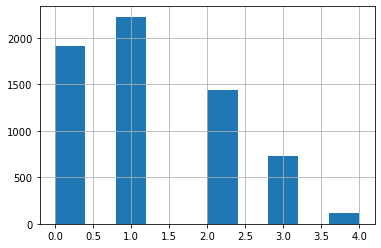

In [64]:
df_new['non_euro_score'].hist()

<AxesSubplot:>

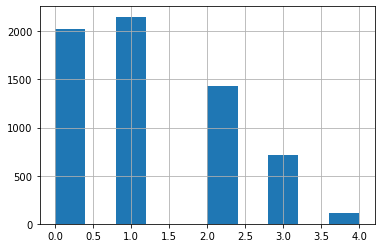

In [65]:
df_new['euro_score'].hist()

In [66]:
df_new.mean()

euro_score        1.182610
non_euro_score    1.208742
dtype: float64

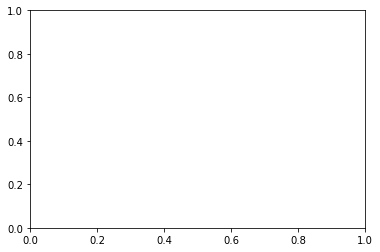

In [67]:
from scipy.stats import skellam
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

In [112]:
df_new.head()

,date,euro_score,non_euro_score,year,Euro_Team,Other_Team,diff
93,1903-04-05,2,1,1903,Europe,Not Europe,1
117,1906-04-01,1,1,1906,Europe,Not Europe,0
161,1909-05-29,2,4,1909,Europe,Not Europe,2
232,1912-07-03,2,1,1912,Europe,Not Europe,1
243,1912-12-01,0,1,1912,Europe,Not Europe,1


## Modelling skellam using MOM

In [68]:
mu1 = 1.18
mu2 = 1.20

In [69]:
from scipy.stats import skellam
import matplotlib.pyplot as plt
%matplotlib inline

In [70]:
mean, var, skew, kurt = skellam.stats(mu1, mu2, moments='mvsk')

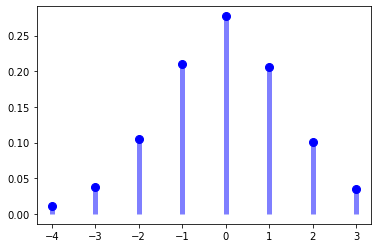

In [113]:
#fix by Pranshu Dixit for visual representation of skellam.ppf
fig, ax = plt.subplots(1, 1)
x = np.arange(skellam.ppf(0.01, mu1, mu2),
              skellam.ppf(0.99, mu1, mu2))
ax.plot(x, skellam.pmf(x, mu1, mu2), 'bo', ms=8, label='skellam pmf')
ax.vlines(x, 0, skellam.pmf(x, mu1, mu2), colors='b', lw=5, alpha=0.5)

In [72]:
rv = skellam(mu1, mu2)
ax.vlines(x, 0, rv.pmf(x), colors='k', linestyles='-', lw=1,
        label='frozen pmf')
ax.legend(loc='best', frameon=False)
plt.show()

In [73]:
#checking accuracy of cdf and ppf
prob = skellam.cdf(x, mu1, mu2)
np.allclose(x, skellam.ppf(prob, mu1, mu2))

True

In [74]:
#generating random numbers from the distribution
r = skellam.rvs(mu1, mu2, size=1000)
#r

Function to find changes that the difference in their score is 0 - i.e, Draw

In [75]:
def prob():
    if ~df_new['home_team'].equals(df_new['away_team']):
        return skellam.pmf(0.0,  df_new.mean()[0],  df_new.mean()[1])

In [76]:
prob()

0.27718369529093473

In [77]:
df_new.head()

,date,home_team,away_team,euro_score,non_euro_score
93,1903-04-05,Europe,Not Europe,2,1
117,1906-04-01,Europe,Not Europe,1,1
161,1909-05-29,Europe,Not Europe,2,4
232,1912-07-03,Europe,Not Europe,2,1
243,1912-12-01,Not Europe,Europe,0,1


## Skellam using bayesian approach with sklearn

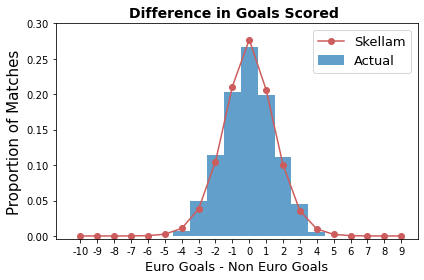

In [78]:
skellam_pred = [skellam.pmf(i, df_new.mean()[0],  df_new.mean()[1]) for i in range(-10,10)]

plt.hist(df_new[['euro_score']].values - df_new[['non_euro_score']].values, range(-10,10), 
         alpha=0.7, label='Actual',density=True)
plt.plot([i+0.5 for i in range(-10,10)], skellam_pred,
                  linestyle='-', marker='o',label="Skellam", color = '#CD5C5C')
plt.legend(loc='upper right', fontsize=13)
plt.xticks([i+0.5 for i in range(-10,10)],[i for i in range(-10,10)])
plt.xlabel("Euro Goals - Non Euro Goals",size=13)
plt.ylabel("Proportion of Matches",size=15)
plt.title("Difference in Goals Scored ",size=14,fontweight='bold')
plt.ylim([-0.004, 0.30])
plt.tight_layout()
plt.show()

In [79]:
skellam_pred

[1.9105426102311516e-07,
 1.6009267645217616e-06,
 1.210704015809449e-05,
 8.169619554777704e-05,
 0.0004849599426790116,
 0.0024871935405546197,
 0.010762834487880159,
 0.0380500816084369,
 0.10496741147770881,
 0.21090795872465906,
 0.27718369529093473,
 0.20634837346333584,
 0.10047792334335222,
 0.03563525223174877,
 0.009861863516377339,
 0.0022297182512966275,
 0.00042535775667055376,
 7.010651895487191e-05,
 1.0164888874034552e-05,
 1.3150558544003993e-06]

## Individual poisson distribution

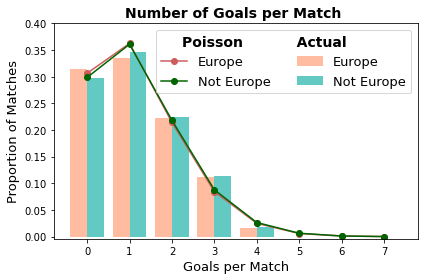

In [80]:
# construct Poisson  for each mean goals value
poisson_pred = np.column_stack([[poisson.pmf(i, df_new.mean()[j]) for i in range(8)] for j in range(2)])

# plot histogram of actual goals
plt.hist(df_new[['euro_score', 'non_euro_score']].values, range(9), 
         alpha=0.7, label=['Europe', 'Not Europe'],density=True, color=["#FFA07A", "#20B2AA"])

# add lines for the Poisson distributions
pois1, = plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,0],
                  linestyle='-', marker='o',label="Europe", color = '#CD5C5C')
pois2, = plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,1],
                  linestyle='-', marker='o',label="Not Europe", color = '#006400')

leg=plt.legend(loc='upper right', fontsize=13, ncol=2)
leg.set_title("Poisson           Actual        ", prop = {'size':'14', 'weight':'bold'})

plt.xticks([i-0.5 for i in range(1,9)],[i for i in range(8)])
plt.xlabel("Goals per Match",size=13)
plt.ylabel("Proportion of Matches",size=13)
plt.title("Number of Goals per Match ",size=14,fontweight='bold')
plt.ylim([-0.004, 0.4])
plt.tight_layout()
plt.show()

In [81]:
#Extracting Year from date
df_new['date'] = pd.to_datetime(df_new.date,format="%Y-%m-%d")
df_new['year'] = df_new.date.dt.year

In [82]:
df_new.columns

Index(['date', 'home_team', 'away_team', 'euro_score', 'non_euro_score',
       'year'],
      dtype='object')

In [83]:
df_new.head(10)

,date,home_team,away_team,euro_score,non_euro_score,year
93,1903-04-05,Europe,Not Europe,2,1,1903
117,1906-04-01,Europe,Not Europe,1,1,1906
161,1909-05-29,Europe,Not Europe,2,4,1909
232,1912-07-03,Europe,Not Europe,2,1,1912
243,1912-12-01,Not Europe,Europe,0,1,1912
257,1913-05-04,Not Europe,Europe,4,1,1913
265,1913-09-14,Not Europe,Europe,1,1,1913
288,1914-07-05,Europe,Not Europe,2,2,1914
289,1914-07-12,Europe,Not Europe,1,1,1914
322,1916-08-20,Europe,Not Europe,2,3,1916


In [84]:
df_new['Euro_Team'] = 'Europe'
df_new['Other_Team'] = 'Not Europe'

In [85]:
df_new= df_new.drop(['home_team', 'away_team'], axis = 1)

In [86]:
df_new.head()

,date,euro_score,non_euro_score,year,Euro_Team,Other_Team
93,1903-04-05,2,1,1903,Europe,Not Europe
117,1906-04-01,1,1,1906,Europe,Not Europe
161,1909-05-29,2,4,1909,Europe,Not Europe
232,1912-07-03,2,1,1912,Europe,Not Europe
243,1912-12-01,0,1,1912,Europe,Not Europe


In [87]:
df_new.shape

(6429, 6)

In [88]:
df_new['diff']= abs(df_new['euro_score']-df_new['non_euro_score'])

In [89]:
df_new.head()

,date,euro_score,non_euro_score,year,Euro_Team,Other_Team,diff
93,1903-04-05,2,1,1903,Europe,Not Europe,1
117,1906-04-01,1,1,1906,Europe,Not Europe,0
161,1909-05-29,2,4,1909,Europe,Not Europe,2
232,1912-07-03,2,1,1912,Europe,Not Europe,1
243,1912-12-01,0,1,1912,Europe,Not Europe,1


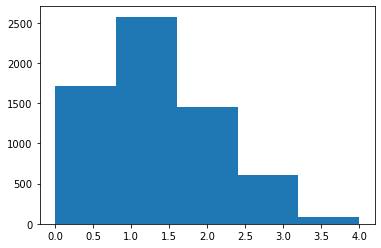

In [90]:
plt.hist(df_new['diff'], bins=len(set(df_new['diff'])));

In [91]:
diff_mean = np.mean(df_new['diff'])
diff_std = np.std(df_new['diff'])
diff_mean, diff_std

(1.1864986778659201, 0.9754641289135652)

In [92]:
df_new['euro_score'].mean()

1.1826100482190076

In [93]:
df_new['euro_score'].var()

1.1041717180135497

In [94]:
df_new['non_euro_score'].mean()

1.2087416394462591

In [95]:
df_new['non_euro_score'].var()

1.0986105662512078

In [96]:
df_new['euro_score'].max()

4

In [97]:
df_new['non_euro_score'].max()

4

The Poisson distribution is defined by the rate parameter, λ, which is the expected number of events in the interval (events/interval * interval length) and the highest probability number of events.

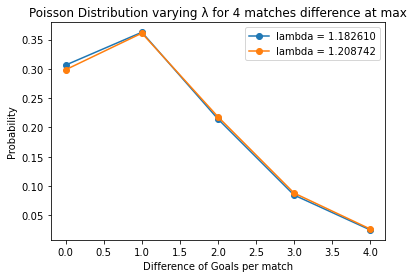

In [98]:
import scipy.stats as stats
for lambd in (df_new['euro_score'].mean(),df_new['non_euro_score'].mean()):
    #n is the number for which we want to compute the probability ( 0 to 4 inclusive)
    n = np.arange(0,5)
    poisson = stats.poisson.pmf(n, lambd)
    plt.plot(n,poisson,'-o',label = "lambda = {:f}".format(lambd))
    plt.xlabel('Difference of Goals per match')
    plt.ylabel('Probability')
    plt.title("Poisson Distribution varying λ for 4 matches difference at max")
    plt.legend()

In [99]:
from scipy.stats import poisson
for i in range(0,10):
    print("Probability of scoring {} goal difference in a match: {}".format(i,poisson.pmf(k=i, mu=diff_mean)))

Probability of scoring 0 goal difference in a match: 0.30528830765380677
Probability of scoring 1 goal difference in a match: 0.36222417339916596
Probability of scoring 2 goal difference in a match: 0.21488925141459314
Probability of scoring 3 goal difference in a match: 0.08498860423033736
Probability of scoring 4 goal difference in a match: 0.025209716638241304
Probability of scoring 5 goal difference in a match: 0.005982259092129559
Probability of scoring 6 goal difference in a match: 0.00118299041724385
Probability of scoring 7 goal difference in a match: 0.00020051665228398282
Probability of scoring 8 goal difference in a match: 2.9739092853130754e-05
Probability of scoring 9 goal difference in a match: 3.920599372352391e-06


In [100]:
skellam.pmf(0.0,  df_new.mean()[0],  df_new.mean()[1])

0.27718369529093473

# Using reference given by Professor with pymc3

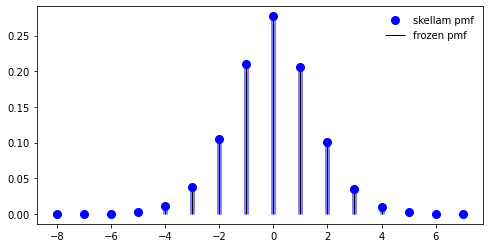

In [101]:
from scipy.stats import skellam
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1,figsize = (8,4))
mu1, mu2 = df_new['euro_score'].mean(), df_new['non_euro_score'].mean()
mean, var, skew, kurt = skellam.stats(mu1, mu2, moments='mvsk')
x = np.arange(skellam.ppf(0.00001, mu1, mu2),
              skellam.ppf(0.99999, mu1, mu2))
ax.plot(x, skellam.pmf(x, mu1, mu2), 'bo', ms=8, label='skellam pmf')
ax.vlines(x, 0, skellam.pmf(x, mu1, mu2), colors='b', lw=5, alpha=0.5)
rv = skellam(mu1, mu2)
ax.vlines(x, 0, rv.pmf(x), colors='k', linestyles='-', lw=1,
        label='frozen pmf')
ax.legend(loc='best', frameon=False)
plt.show()

In [102]:
import numpy as np
import pymc3
import theano
import pandas
import scipy.stats

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [103]:
# copied from theano master branch

from __future__ import absolute_import, print_function, division
# Definitions of theano.scalar ops that have their python implementation taken
# from SciPy. As SciPy is not always available, we treat them separately.

import numpy as np

import theano
from theano.gradient import grad_not_implemented
from theano.scalar.basic import (UnaryScalarOp, BinaryScalarOp,
                                 exp, upgrade_to_float,
                                 upgrade_to_float64,
                                 float_types)
from theano.scalar.basic import (upgrade_to_float_no_complex,
                                 complex_types, discrete_types,
                                 upcast)

imported_scipy_special = False
try:
    import scipy.special
    import scipy.stats
    imported_scipy_special = True
# Importing scipy.special may raise ValueError.
# See http://projects.scipy.org/scipy/ticket/1739
except (ImportError, ValueError):
    pass

class Iv(BinaryScalarOp):
    """
    Modified Bessel function of the first kind of order v (real).
    """

    @staticmethod
    def st_impl(v, x):
        return scipy.special.iv(v, x)

    def impl(self, v, x):
        if imported_scipy_special:
            return self.st_impl(v, x)
        else:
            super(Iv, self).impl(v, x)

    def grad(self, inputs, grads):
        v, x = inputs
        gz, = grads
        return [grad_not_implemented(self, 0, v),
                gz * (iv(v - 1, x) + iv(v + 1, x)) / 2.]

iv = Iv(upgrade_to_float, name='iv')

# added:
iv_tensor = theano.tensor.elemwise.Elemwise(iv)

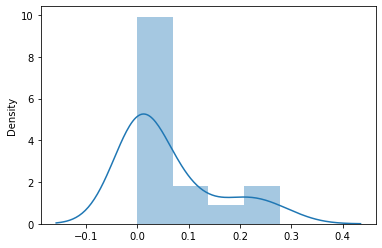

In [104]:
Y = skellam.pmf(x, mu1, mu2)
sns.distplot(Y);

# Ques in cell below

In [105]:
# use class, because nested function cannot be pickled
class skellam_log:
    def __init__(self, mu1, mu2):
        self.mu1 = mu1
        self.mu2 = mu2
    def __call__(self, k):
        total = (-mu1-mu2)+(theano.tensor.log(mu1)-theano.tensor.log(mu2))*k/2
        log_prob = total+ theano.tensor.log(iv_tensor(k, 2*theano.tensor.sqrt(mu1*mu2)))
        return log_prob

with pymc3.Model() as model:
    
    beta0 = pymc3.Normal('beta0',mu=df_new['euro_score'].mean(),sd=100)
    beta1 = pymc3.Normal('beta1',mu=df_new['non_euro_score'].mean(),sd=100)
    
    #mean = beta0 - beta1
    
    #var = pymc3.DiscreteUniform('var',lower=1, upper=1000)
     
    # why this calculation of mu1 and mu2??
    #mu1, mu2 = df_new['euro_score'].mean(), df_new['non_euro_score'].mean()
    #mu1 = (var + mean)/2
    #mu2 = (var - mean)/2
    
    obs = pymc3.DensityDist('obs', skellam_log(beta0,beta1), observed=Y)
    
    trace = pymc3.sample(2000, cores=1, tune=500, nuts={'target_accept':0.99})

Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [beta1, beta0]
>Metropolis: [var]
Sampling chain 1, 0 divergences: 100%|████████████████████████████████████████████| 2500/2500 [00:14<00:00, 166.89it/s]
The number of effective samples is smaller than 25% for some parameters.


AttributeError: 'int' object has no attribute 'astype'

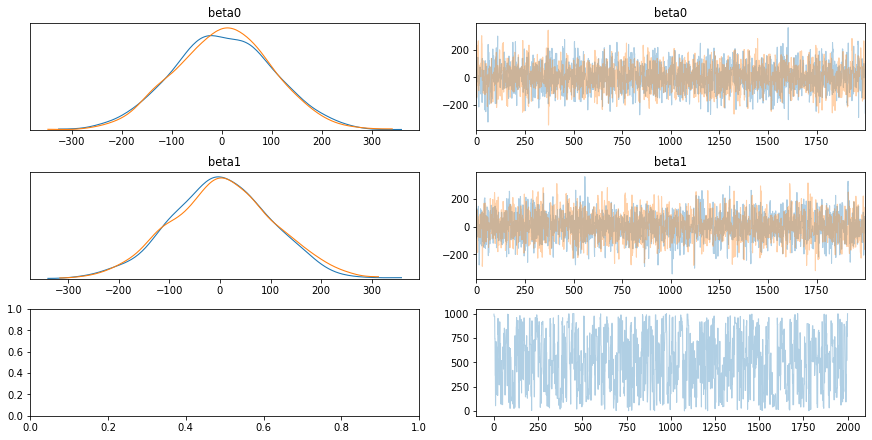

In [273]:
_ = pymc3.traceplot(trace)

In [110]:
# use class, because nested function cannot be pickled
class skellam_log:
    def __init__(self, mu1, mu2):
        self.mu1 = mu1
        self.mu2 = mu2
    def __call__(self, k):
        total = (-mu1-mu2)+(theano.tensor.log(mu1)-theano.tensor.log(mu2))*k/2
        log_prob = total+ theano.tensor.log(iv_tensor(k, 2*theano.tensor.sqrt(mu1*mu2)))
        return log_prob

with pymc3.Model() as model:
    
    beta0 = pymc3.Poisson('beta0',mu=df_new['euro_score'].mean(),observed = df_new['euro_score'])
    beta1 = pymc3.Poisson('beta1',mu=df_new['non_euro_score'].mean(),observed = df_new['non_euro_score'])
    
    #mean = beta0 - beta1
    
    var = pymc3.DiscreteUniform('var',lower=1, upper=1000)
     
    # why this calculation of mu1 and mu2??
    #mu1, mu2 = df_new['euro_score'].mean(), df_new['non_euro_score'].mean()
    #mu1 = (var + mean)/2
    #mu2 = (var - mean)/2
    
    obs = pymc3.DensityDist('obs', skellam_log(beta0,beta1), observed=Y)
    
    trace = pymc3.sample(2000, cores=1, tune=500)

Sequential sampling (2 chains in 1 job)
Metropolis: [var]
Sampling chain 1, 0 divergences: 100%|███████████████████████████████████████████| 2500/2500 [00:00<00:00, 3805.06it/s]
The number of effective samples is smaller than 25% for some parameters.
